In [1]:
import numpy as npp
import matplotlib.pyplot as plt
from IPython.core.display import HTML
#this css file can be downloaded from [David's repo](https://github.com/ketch/PseudoSpectralPython/blob/master/custom.css)
#Then set the address of css file as per your address of file
#Following two commands are not needed for calculations.
css_file = '/Users/rajvanmp/Downloads/custom.css'

#HTML(open(css_file, "r").read())

In [2]:
#Import the needed classes.
#GPE_Scalar_Field is the class for representing the GP-like fields(as defined in repo home)
import sys

sys.path.append('../')
from GPE import GPE_scalar_field_relax
from GPE import GPE_scalar_field

#ImEx is just a class for holding no. of stages and Butcher Tableau for ImEx methods
from GPE import ImEx


def choose_imex(imex_scheme="default"):
    from Biswas_Ketcheson_TimeIntegrators import ImEx_schemes

    if imex_scheme=="default":
        print("Choosin default ImEx")
        A_ex    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
        A_im = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
        b_ex = np.array([24/55.,1./5,4./11])
        b_im = b_ex     
        C=None
        imex_stages=3
    if imex_scheme=="a":
        #3rd order ImEx with b This method is taken from Implicit-explicit 
        # Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.
        print("Using 3rd order ImEx with b  This method is taken from Implicit-explicit Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.")

        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(4,3,2,2)
        b_ex = b_im
        imex_stages=4

    if imex_scheme=="b":
        #3rd order ImEx with b. This method is taken from Additive Runge–Kutta schemes 
        #for convection–diffusion–reaction equations by Kennedy and Carpenter.
        print("Using 3rd order ImEx with b . This method is taken from Additive Runge–Kutta schemes for convection–diffusion–reaction equations by Kennedy and Carpenter.")
        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(4,3,2,3)
        b_ex = b_im
        imex_stages=4
    if imex_scheme=="c":
        #4th order ImEx with b and 3rd order ImEx with bhat. This method is taken from Additive Runge–Kutta schemes 
        #for convection–diffusion–reaction equations by Kennedy and Carpenter.
        print("4th order ImEx with b. This method is taken from Additive Runge–Kutta scheme for convection–diffusion–reaction equations by Kennedy and Carpenter.")
        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(6,4,3,4)
        b_ex = b_im
        imex_stages=6

    return A_im,A_ex,C,b_im,b_ex,imex_stages

In [3]:
import numpy as np
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)

fft = np.fft.fft
ifft = np.fft.ifft


bta = -8.0
a= bta*bta/16.0
c = 0.5
xo = -2.5

def exact_soln(t,x):
    omg = np.sqrt(a)*((x-xo)-c*t)
    #print("omg shape",omg.shape)
    f = (2.0*a/bta)/np.cosh(omg)
    thta = 0.5*c*(x-xo) - (0.25*c*c -a)*t
    
    sol = f*np.cos(thta)+1j*f*np.sin(thta)
    
    return(sol)

def plot_solution(frames, uuhat, x, tt, xi):
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    line, = axes.plot(x,np.square(np.abs(frames[0])),lw=3)
    sol = np.square(np.abs(exact_soln(0.0,x)))
    line2, = axes2.plot(x,sol,lw=3)
    xi_max = np.max(np.abs(xi))
    #axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    #axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    axes.set_xlabel(r'$x$',fontsize=30)
    axes2.set_xlabel(r'$\xi$',fontsize=30)
    plt.tight_layout()
    plt.close()

    def plot_frame(i):
        line.set_data(x,np.square(np.abs(frames[i])))
        sol = np.square(np.abs(exact_soln(tt[i],x)))
        line2.set_data(x,sol)
        #line.set_data(x,sol)
        #line.set_data(x,s)
        #power_spectrum = np.abs(uuhat[i])**2
        #line2.set_data(np.sort(xi),power_spectrum[np.argsort(xi)])
        axes.set_title('t= %.2e' % tt[i])
        #axes.set_xlim((-20,20))
        #axes.set_ylim((-2,2))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frames), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

\begin{equation}
\frac{\partial \psi}{\partial t} = rhs\_f + im\_rhs
\end{equation}
i.e. all the contributions for explicit method are given by rhs_f in following code while im_rhs calculates implicitly treated term's contribution. For example in KdV case:
\begin{equation}
im\_rhs = i u_{xx}
\end{equation}
\begin{equation}
rhs\_f = -i \beta |u|^2u
\end{equation}

In [4]:
#Example NLS 1d
'''
# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)

#4A42
ex_A = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],[0.5,0.0,0.0,0.0,0.0,0.0],[0.25,0.25,0.0,0.0,0.0,0.0],[0.0,-1.0,2.0,0.0,0.0,0.0],[1.0/6.0,0.0,2.0/3.0,1.0/6.0,0.0,0.0],[1.0/6.0,0.0,2.0/3.0,1.0/6.0,0.0,0.0]])
im_A = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.5,0.0,0.0,0.0,0.0],[0.25,-0.25,0.5,0.0,0.0,0.0],[0.0,1.0,0.0,0.0,0.0,0.0],[1.0/6.0,0.0,2.0/3.0,-4.0/3.0,1.5,0.0],[1.0/6.0,0.0,2.0/3.0,1.0/6.0,-2.0,2.0]])
ex_b = np.array([1.0/6.0,0.0,2.0/3.0,1.0/6.0,0.0,0.0])
im_b = np.array([1.0/6.0,0.0,2.0/3.0,1.0/6.0,-2.0,2.0])


imx = ImEx(6,im_A,ex_A,im_b,ex_b)
'''

imA = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],
[0.25,0.25,0.0,0.0,0.0,0.0],
[8611.0/62500.0,-1743.0/31250,0.25,0.0,0.0,0.0],
[5012029.0/34652500.0,-654441.0/2922500.0,174375.0/388108.0,0.25,0.0,0.0],
[15267082809.0/155376265600.0,-71443401.0/120774400.0, 730878875.0/902184768.0, 2285395.0/8070912.0,0.25,0.0],
[82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0, -2260.0/8211.0, 0.25]])

exA = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],
[0.5,0.0,0.0,0.0,0.0,0.0],
[13861.0/62500,  6889.0/62500.0,0.0,0.0,0.0,0.0],
[-116923316275.0/2393684061468.0, -2731218467317.0/15368042101831.0, 9408046702089.0/11113171139209.0, 0.0,0.0,0.0],
[-451086348788.0/2902428689909.0, -2682348792572.0/7519795681897.0, 12662868775082.0/11960479115383.0,3355817975965.0/11060851509271.0,0.0,0.0],
[647845179188.0/3216320057751.0,73281519250.0/8382639484533.0, 552539513391.0/3454668386233.0, 3354512671639.0/8306763924573.0,4040.0/17871.0,0.0]])

imb = np.array([82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0,-2260.0/8211.0,0.25])
exb = np.array([82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0,-2260.0/8211.0,0.25])

imC = np.array([0.0,0.5,83.0/250.0,31.0/50.0, 17.0/20.0,1.0])
exC = np.array([0.0,0.5,83.0/250.0,31.0/50.0, 17.0/20.0,1.0])

imex_sch = "c"
A_im,A_ex,C,b_im,b_ex,imex_stages = choose_imex(imex_sch)  

    # Initialize imex table for simulation
imx = ImEx(imex_stages,A_im,A_ex,b_im,b_ex)


###   PARAMETERS

bta = -8.0
#a= bta*bta/16.0
#c = 0.5
#xo = -2.5

#def exact_soln(t,x):
#    omg = np.sqrt(a)*((x-xo)-c*t)
#    #print("omg shape",omg.shape)
##    f = (2.0*a/bta)/np.cosh(omg)
 #   thta = 0.5*c*(x-xo) - (0.25*c*c -a)*t
 #   
 #   sol = f*np.cos(thta)+1j*f*np.sin(thta)
    
 #   return(sol)

def exact_soln(t,x):
    sechx = 1./np.cosh(x)
    ut = np.exp(1j*t)*sechx*( 1+(3/4)*sechx**2*(np.exp(8*1j*t)-1) )/( 1-(3/4)*sechx**4*np.sin(4*t)**2 )

    return(ut)
    

#Defining right hand side for the PDE, which contains everything EXCEPT laplacian term. If you are using filtering..
#..filtr should be passed here as an argument as shown

def rhs_f(u, xi, filtr):
    # Evaluate only the non-stiff nonlinear term
    u2 = np.square(np.abs(u))
    return -1j*bta*u2*u

#Please note that following function doesn't use filtr at all, but for the convenience of supporting...
#..functions with varying length of arguement list, we just pass same argument list (after 1st argument) to..
#..both im_rhs and rhs_f
#So, the format is: we pass (sub_stage_no,arg_list) to class method ::update_K(sub_stage_no,arg_method) which...
#..then passes (psi_k,arg_list) to rhs_f(psi_k,arg_list) and (ft_psi_k,arg_list) to im_rhs(ft_psi_k,arg_list)..
#..where psi_k is temporary sub-stage solution while ft_psi_k is Fourier Transform of same.

def im_rhs(psi_ft,xi,filtr):
    psi_ft = -psi_ft*(xi**2)
    return(1j*np.fft.ifft(psi_ft))


def solve_NLS_1d(m,dt,relax=False,use_filter=False):
    max_err=-1.0
    L = 2*40.0
    x = np.arange(-m/2,m/2)*(L/m)
    xi = np.fft.fftfreq(m)*m*2*np.pi/L

    dx = L/m

    tmax = 5.0

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    print(nplt,nmax)
    
    uin = exact_soln(0.0,x)
    mass_ini = np.sum(np.square(np.real(uin))+np.square(np.imag(uin)))*(L/m)
    print("Mass ini",mass_ini)

    
    frames = [uin.copy()]
    tt = []
   

    filtr = np.ones_like(xi)
    
    err_list=[]
    real_err_list=[]
    mass_err_list=[]
    
    #Define psi as an instance of class GPE_scalar_field
    #1st argument sets the space-dim of problem. In this 
    #case of 1-d problem, it is 1. Next argument(m here)
    #gives no. of points in space, then we pass im_rhs
    #and rhs_f functions followed by ImEx object. Last 
    #argument passes a scalar array uin which is initial
    #condition at t=0. Note that it as passed as a complex array
    #if relax:
    psi = GPE_scalar_field_relax(1,m,im_rhs,rhs_f,imx,uin,relax)
    #else:
    #    psi = GPE_scalar_field(1,m,im_rhs,rhs_f,imx,uin)
    print("Relax",relax)
    lmbda = xi**2
    
    if use_filter:
        xi_max = np.max(np.abs(xi))
        filtr[np.where(np.abs(xi)>xi_max*2./3)] = 0.
    
    t=0.0
    n=0
    
    print(np.sum(np.square(np.abs(psi.psi))))

    exc_sol = exact_soln(t,x)
    real_err = np.sum(np.abs(exc_sol.real-psi.psi.real))/np.sum(np.abs(exc_sol.real))
    err2 = np.square(np.abs(exc_sol-psi.psi)).flatten()
    sol2 = np.square(np.abs(exc_sol)).flatten()
    err2_norm = np.sqrt(np.sum(err2))
    sol2_norm = np.sqrt(np.sum(sol2))
    err = err2_norm/sol2_norm
            
                
    mass = np.sum(np.conj(psi.psi)*psi.psi)*(L/m)
    mass_err = np.abs(mass-mass_ini)#/mass_ini
            
    print("time ",t/tmax,"mass",mass,err,mass_err,psi.rel_gamma)
            
    frames.append(psi.psi)
    #tt.append(t)
            
    #err_list.append(err)
    #real_err_list.append(real_err)
    #mass_err_list.append(mass_err)
    
    while(t<=tmax):
        #for each stage
        for k in range(imx.s):
            
            #update summation for input to FFT for calc. implicit contribution
            psi.update_stage_sum(k,dt)
            
            #Do fft,mulitply by needed functions and do inverse fft
            psi.do_fft(k,lmbda,dt)
            
            #update im_K and ex_K i.e. stage contributions
            psi.update_K(k,dt,xi,filtr)
            
        #Sum over stage contributions
        psi.sum_contributions(dt)
        
        
        t = t+(psi.rel_gamma)*dt
        n=n+1
        
        if np.mod(n,nplt) == 0:
            
            exc_sol = exact_soln(t,x)
            real_err = np.sum(np.abs(exc_sol.real-psi.psi.real))/np.sum(np.abs(exc_sol.real))
            err2 = np.square(np.abs(exc_sol-psi.psi)).flatten()
            sol2 = np.square(np.abs(exc_sol)).flatten()
            err2_norm = np.sqrt(np.sum(err2))
            sol2_norm = np.sqrt(np.sum(sol2))
            err = err2_norm/sol2_norm
            
                
            mass = np.sum(np.conj(psi.psi)*psi.psi)*(L/m)
            mass_err = np.abs(mass-mass_ini)#/mass_ini
            
            print("time ",t/tmax,"mass",mass,err,mass_err,psi.rel_gamma)
            
            frames.append(psi.psi)
            tt.append(t)
            
            err_list.append(err)
            real_err_list.append(real_err)
            mass_err_list.append(mass_err)


       
    return frames,tt, np.array(err_list),np.array(real_err_list),np.array(mass_err_list)

4th order ImEx with b. This method is taken from Additive Runge–Kutta scheme for convection–diffusion–reaction equations by Kennedy and Carpenter.


Running dt 0.01 i 0
10.0 500
Mass ini 2.0
class shapes (1120,) (6, 1120)
(1120,) (1120,)
Relax False
28.0
time  0.0 mass (2+0j) 0.0 0.0 1.0
time  0.019999999999999997 mass (1.999999890370256-8.280125457019006e-18j) 5.151982461187064e-07 1.0962974394956859e-07 1.0
time  0.04000000000000001 mass (1.9999989435457255+6.017187911413598e-18j) 3.8929909782522955e-06 1.05645427450618e-06 1.0
time  0.06000000000000002 mass (1.9999865418699485+1.9755804344441507e-17j) 2.7416806618465163e-05 1.3458130051491324e-05 1.0
time  0.08000000000000004 mass (1.9999220974806236-9.631243081293069e-18j) 0.00010159419372876239 7.790251937644932e-05 1.0
time  0.10000000000000005 mass (1.9999012988317206+4.0226365631789273e-19j) 0.00030373892478061045 9.870116827936926e-05 1.0
time  0.12000000000000006 mass (1.9999025483235562-3.0363895059437457e-18j) 0.00040478942326273336 9.745167644381603e-05 1.0
time  0.14000000000000007 mass (1.9999028097252618+2.8356130008959333e-18j) 0.0004985926423084539 9.7190274738201

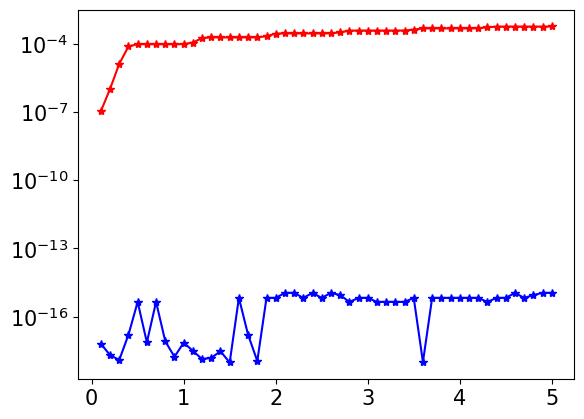

In [6]:
m = 1120
umax = 3000
dt = 0.01
use_filter=False
err_list = []
err_real_list = []
mass_err_list = []
dt_list = []
for i in range(1):
    print("Running dt",dt,"i",i)
    dt_list.append(dt)
    frames,tt,err,real_err,mass_err = solve_NLS_1d(m,dt,relax=False,use_filter=use_filter)
    dt=dt*0.5
    
    err_list.append(np.max(err))
    err_real_list.append(np.max(real_err))
    mass_err_list.append(np.max(mass_err))
    
    print("MAX ERR",np.max(err),np.max(mass_err),np.max(mass_err2))
    
err_mx = np.array(err_list)
err_real_mx = np.array(err_real_list)
mass_err_mx = np.array(mass_err_list)


dt=np.array(dt_list)
plt.yscale("log")
plt.plot(tt,mass_err,"r*-")
plt.plot(tt,mass_err2,"b*-")
print(frames[-1].dtype)

In [ ]:
L=2.0*40.0
m=1024
x1 = np.linspace(-40.0, 40.0, m+1)[:-1]
x2 = np.arange(-m/2,m/2)*(L/m)
print(x1.shape,x2.shape,(x1-x2).max(),(x1-x2).min())
plt.plot(x1-x2)

In [ ]:
#dt = [0.01,0.005,0.001,0.0005]
#errmx = [0.016702785978446447,0.0010412188379402062,8.387384825997046e-07,1.5126489345870342e-07]
i=0
s=-1
print(dt.shape,err_mx.shape)
ldt = np.log10(dt[i:s])
lerrmx = np.log10(err_mx[i:s])


z= np.polyfit(ldt,lerrmx,1)
y = z[0]*ldt+z[1]

plt.plot(ldt,lerrmx,"*-",label="err")
plt.plot(ldt,y,label="fit "+str(z[0])[:4]+"log(dt)+"+str(z[1])[:3])
plt.legend(loc="best")

In [10]:
L = 2*40.0
x = np.arange(-m/2,m/2)*(L/m)
xi = np.fft.fftfreq(m)*m*2*np.pi/L
plot_solution(frames, None, x, tt, xi)

(-2.559208149130665e-35+6.239347904952579e-35j)

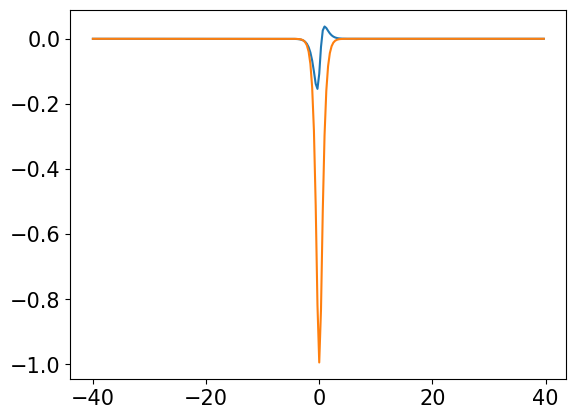

In [17]:
y = exact_soln(5.0,x)
y2 = np.square(np.abs(y))
plt.plot(x,np.real(y))
plt.plot(x,np.imag(y))
y[-1]

In [30]:
a  = np.random.rand(5)+1j*np.random.rand(5)
b  = np.random.rand(5)+1j*np.random.rand(5)
c = np.conj(a)*b+np.conj(b)*a

In [14]:
a = frames[-1]

dtype('float64')

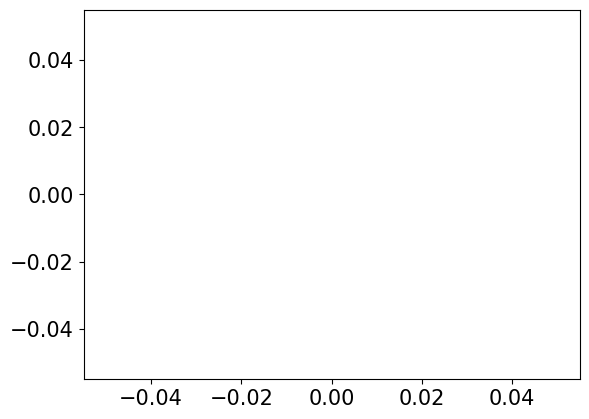

In [8]:
aa=np.conj(a)*a
plt.plot(aa.imag)

aa.max()
aa.dtype